In [1]:
import pandas as pd
import numpy as np

### 데이터 불러오기

In [2]:
selloutData = pd.read_csv('../lee/Python_ST_EX/dataset/kopo_decision_tree_all_new.csv')
selloutData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,A01,PG01,P01,ITEM001,201538,2015,38,1,N,4,N,0.0
1,A01,PG01,P01,ITEM001,201548,2015,48,1,Y,0,N,0.0
2,A01,PG01,P01,ITEM001,201549,2015,49,2,Y,0,N,0.0
3,A01,PG01,P01,ITEM002,201526,2015,26,1,Y,1,N,0.0
4,A01,PG01,P01,ITEM002,201532,2015,32,1,N,4,N,0.0


In [3]:
len(selloutData)

32415

### 1. 지역/상품/아이템별 146개 제품 추출

In [4]:
groupKey = ["REGIONID", "PRODUCTGROUP", "PRODUCT", "ITEM"]

In [5]:
groupData = selloutData.\
                    groupby(groupKey)["YEARWEEK"].\
                    agg(["size"]).reset_index()

In [6]:
groupData.rename(columns={"size":"KNOB"}, inplace=True)

In [7]:
groupData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,KNOB
0,A01,PG01,P01,ITEM001,3
1,A01,PG01,P01,ITEM002,2
2,A01,PG01,P01,ITEM003,1
3,A01,PG01,P01,ITEM004,7
4,A01,PG01,P01,ITEM005,8


In [8]:
len(groupData)

491

In [9]:
mergedData = pd.merge(left=selloutData,
                                     right=groupData,
                                     on = groupKey,
                                    how = "left")
mergedData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,KNOB
0,A01,PG01,P01,ITEM001,201538,2015,38,1,N,4,N,0.0,3
1,A01,PG01,P01,ITEM001,201548,2015,48,1,Y,0,N,0.0,3
2,A01,PG01,P01,ITEM001,201549,2015,49,2,Y,0,N,0.0,3
3,A01,PG01,P01,ITEM002,201526,2015,26,1,Y,1,N,0.0,2
4,A01,PG01,P01,ITEM002,201532,2015,32,1,N,4,N,0.0,2


In [10]:
maxknob = mergedData.KNOB.max()

In [11]:
refinedData = mergedData[mergedData.KNOB >= maxknob]

In [12]:
sortKey = ["REGIONID", "PRODUCTGROUP", "PRODUCT", "ITEM","YEARWEEK"]

In [13]:
sortedData = refinedData.sort_values(sortKey).reset_index(drop=True)

In [14]:
sortedData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,KNOB
0,A01,PG02,P03,ITEM043,201501,2015,1,87,Y,1,Y,0.197590,146
1,A01,PG02,P03,ITEM043,201502,2015,2,60,N,4,Y,0.197590,146
2,A01,PG02,P03,ITEM043,201503,2015,3,51,N,4,N,0.000000,146
3,A01,PG02,P03,ITEM043,201504,2015,4,37,Y,2,N,0.000000,146
4,A01,PG02,P03,ITEM043,201505,2015,5,136,N,4,Y,0.201205,146


In [15]:
sortedData.YEARWEEK.min()

201501

In [16]:
sortedData.YEARWEEK.max()

201741

In [17]:
sortedData.YEARWEEK.describe()

count      7592.000000
mean     201616.917808
std          78.836685
min      201501.000000
25%      201537.000000
50%      201620.500000
75%      201705.000000
max      201741.000000
Name: YEARWEEK, dtype: float64

In [18]:
stdYearweek = 201701

In [19]:
groupKey

['REGIONID', 'PRODUCTGROUP', 'PRODUCT', 'ITEM']

### 그룹단위 머신러닝 시작

In [20]:
groupsData = sortedData.groupby(groupKey)

In [21]:
len(groupsData)

52

In [22]:
repeatNum = 3

In [23]:
list(np.repeat(0,repeatNum))

[0, 0, 0]

In [24]:
def dtPredict(onegroup):
    # 디버깅 코드
    # onegroup = groupsData.get_group(list(groupsData.groups)[2])
    eachgroup = onegroup.reset_index(drop=True)

    ### 1. 특성 선별
    
    corrdf = eachgroup.corr()
    corrdfStd = 0.5
    features = list(corrdf[(abs(corrdf["QTY"]) >= corrdfStd) &
                          (corrdf["QTY"] != 1)].index)
    featuresLen = len(features)
    label = ["QTY"]
    testData_all = eachgroup[eachgroup.YEARWEEK >= stdYearweek]
    testDataSize = len(testData_all)

    if(featuresLen == 0) :
            predict = list(np.repeat(0,testDataSize))
            testData_all["PREDICT"] = predict
    
    else:
        ### 2. 데이터 분리(훈련 / 테스트) *** 단, 특성/답지도 분리해야함! ***

        #훈련할 특성
        trainingData_features = eachgroup[eachgroup.YEARWEEK < stdYearweek][features]
        #훈련할 답지
        trainingData_label = eachgroup[eachgroup.YEARWEEK < stdYearweek][label]

        #검증할 특성
        testData_features = eachgroup[eachgroup.YEARWEEK >= stdYearweek][features]
        #검증할 답지
        testData_label = eachgroup[eachgroup.YEARWEEK >= stdYearweek][label]


        ### 3. 모델 선언

        from sklearn import tree

        model_method = tree.DecisionTreeRegressor(random_state=32)


        ### 4. 훈련(훈련데이터 특성/답지 활용)

        model = model_method.fit(trainingData_features, trainingData_label)


        ### 5. 예측 (test 데이터의 feature)

        testData_all["PREDICT"] = model.predict(testData_features)

    return testData_all

In [25]:
predictResult = sortedData.groupby(groupKey).apply(dtPredict).reset_index(drop=True)

In [26]:
#groupKey가 중복되는 값을 제거한것의 개수
len(predictResult[["REGIONID","PRODUCTGROUP","PRODUCT","ITEM"]].drop_duplicates())

52

### ITEM043 예측치 시각화 해보기(matplotlib 이중축 활용)

In [27]:
import matplotlib.pyplot as plt
import numpy as np
#차트를 만들기 위해 필요한 라이브러리

In [28]:
targetItem = "ITEM043"

In [29]:
targetVisual = predictResult[predictResult.ITEM == targetItem]

In [30]:
x = targetVisual.YEARWEEK
y1 = targetVisual.QTY
y2 = targetVisual.PREDICT

Text(0,0.5,'Expected QTY')

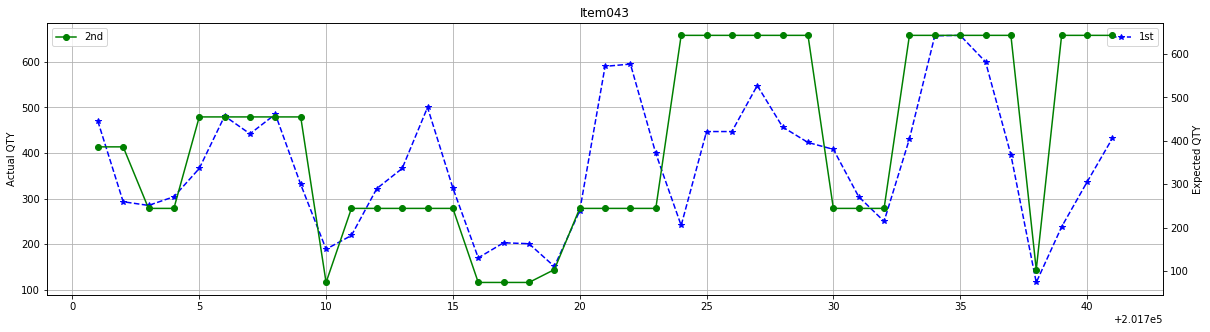

In [31]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,1,1)
plt.plot(x,y1, 'b*--',lw=1.5, label = '1st')
plt.grid(True)
plt.legend(loc=0)
plt.ylabel('Actual QTY')
plt.title('Item043')

ax2 = ax1.twinx()
plt.plot(x,y2, 'go-', lw=1.5, label='2nd')
plt.legend(loc=0)
plt.ylabel('Expected QTY')